# Linear models in TensorFlow 2.0

In this notebook, we will learn how to build, solve, and make predictions with models in TensorFlow 2. We will focus on a simple class of models – the linear regression model – and will try to predict housing prices. We will load and manipulate data, construct loss functions, perform minimization, make predictions, and reduce resource use with batch training.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.1.0'

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

King County housing dataset

In [4]:
housing: pd.DataFrame = pd.read_csv('data/kc_house.csv')
housing_mat: np.ndarray = housing.to_numpy()
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Section 1 Loss functions
### Subsection 1.1 Visulizing loss functions

In [15]:
xs_: np.ndarray = np.linspace(-2, 2)
loss_fns: tuple = ('MAE', 'MSE')


def compute_ys(xs: np.ndarray, fn: str) -> list:
    loss_functions: dict = dict(MAE=tf.keras.losses.mae,
                                MSE=tf.keras.losses.mse)
    ys: list = []
    for x in xs:
        res = loss_functions[fn](np.zeros(5), np.repeat(x, 5))
        ys.append(res.numpy())
    
    return ys


ys_: dict = {loss: compute_ys(xs_, loss) for loss in loss_fns}

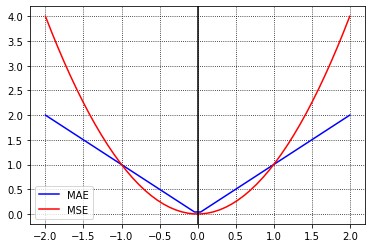

In [19]:
cs: tuple = ('b', 'r')

for i, loss in enumerate(loss_fns):
    plt.plot(xs_, ys_[loss], label=loss, c=cs[i])
plt.axvline(0, color='k')
plt.legend()
plt.grid(c='k', ls=':')
# plt.savefig('out/plots/loss_mae_mse.png', dpi=600, transparent=True)
plt.show()

In [24]:
scalar = tf.Variable(1.0, tf.float32)
targets = np.array([ 2.,  4.,  6.,  8., 10.], dtype=np.float32)
features = np.array([1., 2., 3., 4., 5.], dtype=np.float32)


def model(scalar, features=features):
  	return scalar * features


def loss_function(scalar, features=features, targets=targets):
    predictions = model(scalar, features)
    return tf.keras.losses.mae(targets, predictions)


print(loss_function(scalar).numpy())

3.0


## Section 2 Set up a linear regression

We will create two tensors, one for the property's prices and another for the property's lot size. We will take the natural logarithms of both tensors.

We will define the model and the loss function. We will then evaluate the loss function for two different values of intercept and slope.

In [31]:
price_log: np.ndarray = np.log(housing.price).to_numpy(dtype=np.float32)
size_log: np.ndarray = np.log(housing.sqft_lot).to_numpy(dtype=np.float32)

In [25]:
def linear_regression(intercept, slope, features):
    """Linear regression model."""
    return intercept + features * slope

In [34]:
def loss_function(intercept, slope, targets, features):
    """MSE."""
    predictions = linear_regression(intercept, slope, features)
    return tf.keras.losses.mse(targets, predictions)

In [37]:
print(loss_function(0.1, 0.1, targets=price_log, features=size_log).numpy())
print(loss_function(0.1, 0.5, targets=price_log, features=size_log).numpy())

145.44653
71.866


### Train the linear model

In [40]:
intercept = tf.Variable(5.0, dtype=np.float32)
slope = tf.Variable(0.001, dtype=np.float32)

In [45]:
opt = tf.keras.optimizers.Adam(learning_rate=0.5)

err = []
for j in range(1_000):
    opt.minimize(lambda: loss_function(intercept, slope, targets=price_log, features=size_log),
                 var_list=[intercept, slope])
    err.append(loss_function(intercept, slope, targets=price_log, features=size_log).numpy())

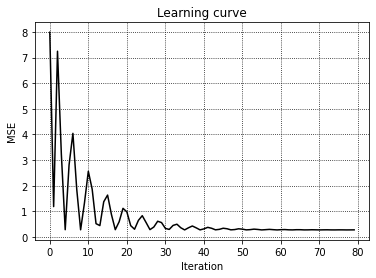

In [73]:
plt.plot(err[:80], c='k')
plt.title('Learning curve')
plt.ylabel('MSE')
plt.xlabel('Iteration')
plt.grid(c='k', ls=':')
plt.show()

In [71]:
def plot_results(intercept, slope, targets, features):
	size_range = np.linspace(6, 14, 100)
	price_pred = [intercept + slope * s for s in size_range]
	plt.scatter(features, targets, color='black', s=5, alpha=0.5)
	plt.plot(size_range, price_pred, linewidth=3.0, color='red')
	plt.xlabel('log(size)')
	plt.ylabel('log(price)');plt.grid(c='k', ls=':')
	plt.title('Scatterplot of data and fitted regression line')
	plt.show()

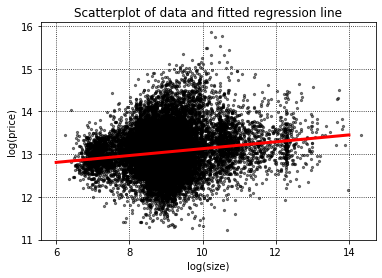

In [72]:
plot_results(intercept, slope, targets=price_log, features=size_log)